# 데이터 관련

In [1]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

###  Google Drive Mount

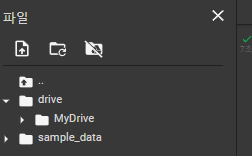

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzip dataset
- 구글 드라이브에 데이터를 저장할 시 I/O 병목으로 인해 train 속도가 느릴 수 있습니다.
- 코랩의 content 디렉토리 아래에 데이터의 압축을 풀어 사용하시기 바랍니다

In [14]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/train.zip
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/valid.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: valid/49/5_49.npy       
  inflating: valid/49/540_49.npy     
  inflating: valid/49/1639_49.npy    
  inflating: valid/49/247_49.npy     
  inflating: valid/49/764_49.npy     
  inflating: valid/49/1280_49.npy    
  inflating: valid/49/129_49.npy     
  inflating: valid/49/1727_49.npy    
  inflating: valid/49/1771_49.npy    
  inflating: valid/49/892_49.npy     
  inflating: valid/49/1874_49.npy    
  inflating: valid/49/1445_49.npy    
  inflating: valid/49/88_49.npy      
  inflating: valid/49/478_49.npy     
  inflating: valid/49/1825_49.npy    
  inflating: valid/49/1913_49.npy    
  inflating: valid/49/1763_49.npy    
  inflating: valid/49/679_49.npy     
  inflating: valid/49/241_49.npy     
  inflating: valid/49/957_49.npy     
  inflating: valid/49/1154_49.npy    
  inflating: valid/49/584_49.npy     
  inflating: valid/49/1719_49.npy    
  inflating: valid/49/559_49.npy     
  inflating: valid/49/87_49.npy      
  inflating: v

In [15]:
# PRINT THE NUMBER OF CLASSES

len(os.listdir('/content/train/'))


52

### Custom dataset & dataloader

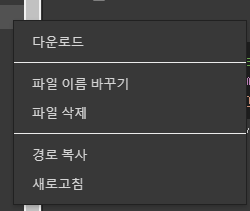

In [16]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

class MyDataset(Dataset):
    def __init__(self, npy_dir, label_dict=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.transpose(0, 1)),
            transforms.Lambda(lambda x: TF.rotate(x, -90))
        ])
        self.npy_path = glob.glob(os.path.join(npy_dir, '*', '*.npy'))
        self.label_dict = label_dict or self.create_label_dict()

    def create_label_dict(self):
        label_dict = {}
        for path in self.npy_path:
            label_name = os.path.basename(os.path.dirname(path))
            if label_name not in label_dict:
                label_dict[label_name] = len(label_dict)
        return label_dict

    def __getitem__(self, index):
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)

        image = data['image']
        image = self.to_tensor(image)
        image = TF.hflip(image)

        label_name = os.path.basename(os.path.dirname(single_data_path))
        label = self.label_dict[label_name]
        label = torch.tensor(label, dtype=torch.long)

        return (image, label)

    def __len__(self):
        return len(self.npy_path)

label_dict = {
    '30': 0, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '36': 6, '37': 7, '38': 8, '39': 9,
    '41': 10, '42': 11, '43': 12, '44': 13, '45': 14, '46': 15, '47': 16, '48': 17, '49': 18,
    '4a': 19, '4b': 20, '4c': 21, '4d': 22, '4e': 23, '50': 24, '51': 25, '52': 26, '53': 27,
    '54': 28, '55': 29, '56': 30, '57': 31, '58': 32, '59': 33, '5a': 34, '61': 35, '62': 36,
    '64': 37, '65': 38, '66': 39, '67': 40, '68': 41, '69': 42, '6a': 43, '6d': 44, '6e': 45,
    '6f': 46, '71': 47, '72': 48, '74': 49, '75': 50, '79': 51,
}



# unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
train_data = MyDataset("/content/train", label_dict)
valid_data = MyDataset("/content/valid", label_dict)

print(len(train_data))
print(len(valid_data))

41600
15600


In [17]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)



# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


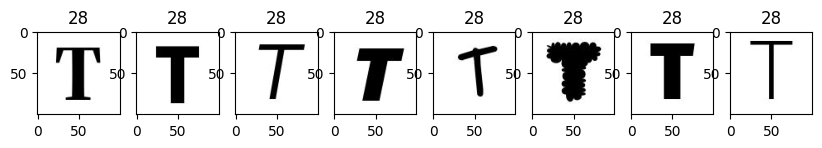

In [18]:
# visualize data
# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+12200][0].squeeze(), cmap="gray")
    plt.title(dataset[i+12200][1].item())  # .item()을 사용하여 텐서에서 숫자로 변환

image_show(train_data, 8)

#학습 환경 관련


### Check GPU Configuration

In [19]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Sun Dec 24 05:05:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              33W /  70W |    269MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Fix seed
42로 Seed를 고정하여 사용하시기 바랍니다.

In [20]:
# FIX SEED
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

**Model Structure **

In [21]:
# Define Hyperparameters
num_classes = 52
in_channel = 1

# Hyper-parameters
# batch_size = 50 (이미 앞에서 정의했으므로 주석 처리)
max_pool_kernel = 2
learning_rate = 0.0002
num_epochs = 15

In [22]:
from torchsummary import summary
class CNN(nn.Module):
  def __init__(self, num_classes=52):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=16, kernel_size=10, stride=2, padding=2), #16x48x48
        nn.BatchNorm2d(num_features=16),
        nn.SiLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) #16x24x24
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2), #32x24x24
        nn.BatchNorm2d(num_features=32),
        nn.SiLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) #32x12x12
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2), #32x12x12
        nn.BatchNorm2d(num_features=32),
        nn.SiLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel) #32x6x6
    )
    self.fc1 = nn.Linear(in_features=32*6*6, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = F.silu(x)
    x = x.reshape(x.size(0),-1)
    x = F.silu(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x

In [23]:
model = CNN().to(device)
summary(model,(1,100,100))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #Adam optimizer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           1,616
       BatchNorm2d-2           [-1, 16, 48, 48]              32
              SiLU-3           [-1, 16, 48, 48]               0
         MaxPool2d-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 24, 24]          12,832
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              SiLU-7           [-1, 32, 24, 24]               0
         MaxPool2d-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 32, 12, 12]          25,632
      BatchNorm2d-10           [-1, 32, 12, 12]              64
             SiLU-11           [-1, 32, 12, 12]               0
        MaxPool2d-12             [-1, 32, 6, 6]               0
           Linear-13                  [-1, 512]         590,336
           Linear-14                  [

In [24]:
# loop with train error, train accuracy, and validation accuracy
import time
start = time.time() # Train 시작 시간 정보 저장

t_err_array=[]
v_err_array=[]
t_acc_array=[]
v_acc_array=[]
best_valid_loss = torch.inf
best_epoch = 0

for epoch in range(num_epochs):
  train_error = 0
  train_correct = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)

    # Forward pass
    output = model(data)

    # Compute loss
    loss = criterion(output, target)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    pred = output.argmax(dim=1, keepdim=True)
    train_correct += pred.eq(target.view_as(pred)).sum().item()
    train_error += loss.item()


  train_error = train_error / len(train_loader)
  train_accuracy = 100. * train_correct / len(train_loader.dataset)

  t_err_array.append(train_error)
  t_acc_array.append(train_accuracy)

  # Validation
  model.eval()
  valid_error = 0
  valid_correct = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(valid_loader):
      data = data.to(device)
      target = target.to(device)

      # Forward pass
      output = model(data)

      # Compute loss
      loss = criterion(output, target)

      # Compute accuracy
      pred = output.argmax(dim=1, keepdim=True)
      valid_correct += pred.eq(target.view_as(pred)).sum().item()
      valid_error += loss.item()

  valid_error = valid_error / len(valid_loader)
  valid_accuracy = 100. * valid_correct / len(valid_loader.dataset)
  v_err_array.append(valid_error)
  v_acc_array.append(valid_accuracy)

  # save model if validation loss decrease
  if valid_error <= best_valid_loss:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_valid_loss, valid_error ))
    best_valid_loss = valid_error
    best_epoch = epoch
    torch.save(model.state_dict(), "20171257.pth")

  print('Epoch: {} \tTrain Error: {:.6f} \tTrain Accuracy: {:.2f}% \tValidation Error: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, train_error, train_accuracy, valid_error, valid_accuracy))

end = time.time() # Train 종료 시간 정보 저장
duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f}minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시

Validation loss decreased (inf --> 0.537094).  Saving model ...
Epoch: 1 	Train Error: 1.597101 	Train Accuracy: 82.31% 	Validation Error: 0.537094 	Validation Accuracy: 96.12%
Validation loss decreased (0.537094 --> 0.192983).  Saving model ...
Epoch: 2 	Train Error: 0.299292 	Train Accuracy: 97.32% 	Validation Error: 0.192983 	Validation Accuracy: 97.72%
Validation loss decreased (0.192983 --> 0.123039).  Saving model ...
Epoch: 3 	Train Error: 0.136511 	Train Accuracy: 98.31% 	Validation Error: 0.123039 	Validation Accuracy: 98.06%
Validation loss decreased (0.123039 --> 0.095009).  Saving model ...
Epoch: 4 	Train Error: 0.082935 	Train Accuracy: 98.80% 	Validation Error: 0.095009 	Validation Accuracy: 98.29%
Validation loss decreased (0.095009 --> 0.068990).  Saving model ...
Epoch: 5 	Train Error: 0.054723 	Train Accuracy: 99.16% 	Validation Error: 0.068990 	Validation Accuracy: 98.63%
Validation loss decreased (0.068990 --> 0.055183).  Saving model ...
Epoch: 6 	Train Error: 0.0

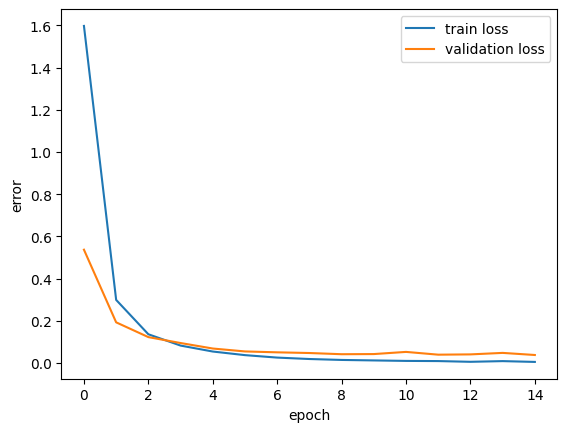

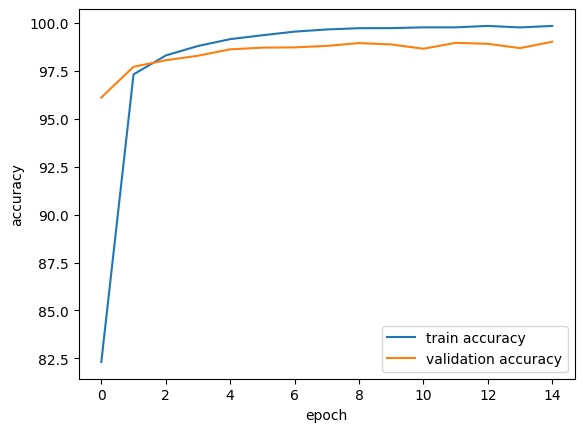

In [25]:
# plot train loss and validation loss

plt.plot(range(num_epochs), t_err_array, label='train loss')
plt.plot(range(num_epochs), v_err_array, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

# plot train accuracy and validation accuracy

plt.plot(range(num_epochs), t_acc_array, label='train accuracy')
plt.plot(range(num_epochs), v_acc_array, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()